In http://localhost:8891/notebooks/caribbean_disaster_risk/03_1_1_result_qc.ipynb we see a relatively low number of 'concrete', 'incomple' and 'other' roof types

Here we boost these numbers.

NB just sharpening all blurred over theshold of 100 in 05_1_fastai_train_resnet_20191027.ipynb led to slightly worse results

#### Env: 
    
    Use solaris conda env

In [1]:
from PIL import Image, ImageOps, ImageFilter
import cv2
from pathlib import Path
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from skimage import data
from skimage.filters import unsharp_mask
from skimage.io import imread
import numpy as np
import os

from imutils import paths
import argparse
import cv2
import shutil
import imgaug
from imgaug import augmenters as iaa
import pandas as pd

In [2]:
data_dir = Path('data')

NB is re-run for different padding types

In [3]:

#BORDER_REFLECT_101
border='clipped'
#BORDER_WRAP
#border='wrap'

In [4]:
#clipped, rotated and reflected images
train_images = data_dir/f'train/rotated/{border}/256'
test_images = data_dir/f'test/rotated/{border}/256'
balanced_dir = data_dir/f'train/rotated/{border}/256/balanced'
balanced_dir.mkdir(exist_ok=True)

In [5]:
fnames = [f for f in listdir(train_images) if isfile(join(train_images, f))]
tnames = [f for f in listdir(test_images) if isfile(join(test_images, f))]

In [6]:
fnames[0]

'7a2e083e.tif'

In [7]:
df_all = pd.read_csv(data_dir/'df_train_all.csv')

In [8]:
df_all['roof_material'].value_counts()

healthy_metal      14817
irregular_metal     5241
concrete_cement     1518
incomplete           669
other                308
Name: roof_material, dtype: int64

In [9]:
low_qty=['irregular_metal','concrete_cement', 'incomplete','other']
df_not_healthy_metal=df_all.loc[df_all['roof_material'].isin(low_qty)]

In [10]:
other_frac=308/14817

In [11]:
1/other_frac

48.107142857142854

In [12]:
incomplete=669/14817

In [13]:
1/incomplete

22.14798206278027

In [14]:
concrete_cement=1518/14817

In [15]:
1/concrete_cement

9.76086956521739

In [16]:
irregular_metal=5241/14817

In [17]:
1/irregular_metal

2.8271322266742986

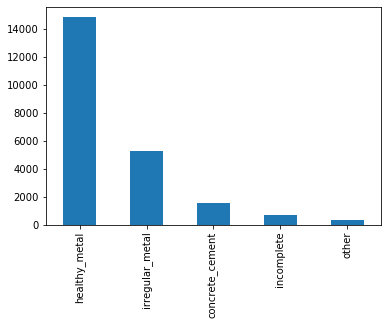

In [18]:
df_all['roof_material'].value_counts().plot(kind='bar')

In [19]:
def mpl_show(new_im, label, title=''):
    plt.imshow(new_im, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    text = label+' '+title
    plt.title(text)
    plt.show()
    plt.close()

In [20]:
def mpl_2_plot(im1, title1, im2, title2):
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(im1)
    plt.title(title1, size=12)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(im2)
    plt.title(title2, size=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()  

In [21]:
def pil_unsharp(image, radius, percent):
    im = Image.open(image)
    im1 = im.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent))
    return im1

### Bluriness calculation
Some images are clearly blurry, lets see if we can identify these
see https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

In [22]:
#focus measures that fall below this value will be considered 'blurry'
threshold=100.0

In [23]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [24]:
def calc_bluriness(images):
    image_quality={}
    i=0
    for imagePath in images:
        # load the image, convert it to grayscale, and compute the
        # focus measure of the image using the Variance of Laplacian
        # method
        if imagePath.endswith('.tif'):
            image = cv2.imread(imagePath)
            try:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                fm = variance_of_laplacian(gray)
                text = "Not Blurry"

                # if the focus measure is less than the supplied threshold,
                # then the image should be considered "blurry"
                if fm < threshold:
                    text = "Blurry"
                id=str(Path(imagePath).name).split('.')[0]
                image_quality[id]=text
                if i<50:
                    mpl_show(image, id, text)
                i+=1
            except Exception as e:
                print(f'error with {imagePath}')
    return image_quality

In [25]:
non_hm=list(df_not_healthy_metal['id'])

In [26]:
non_hm[:1]

['7a3f2a10']

In [27]:
nhm_images=[]
for n in non_hm:
    p=data_dir/f'train/rotated/{border}/256/'
    p=p.absolute()
    p=str(p)+'/'+n+'.tif'
    nhm_images.append(p)

In [28]:
nhm_images[0]

'/mnt/963GB/Data/Python/Code/comps/driven_data/caribbean_disaster_risk/data/train/rotated/wrap/256/7a3f2a10.tif'

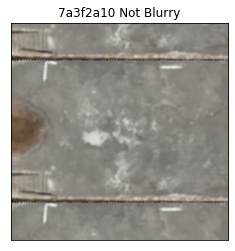

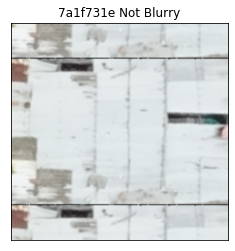

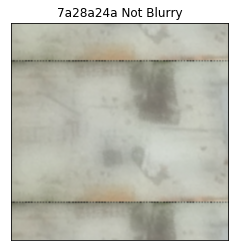

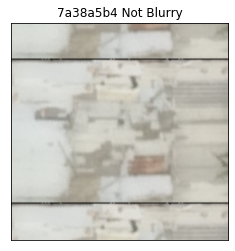

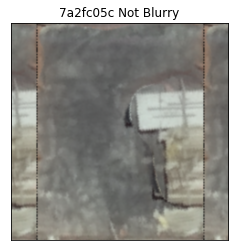

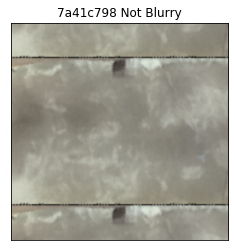

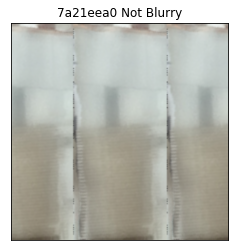

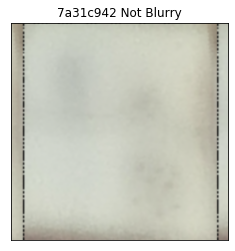

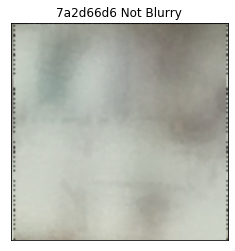

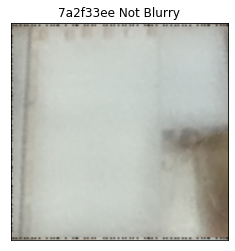

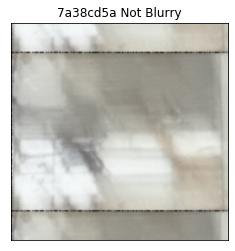

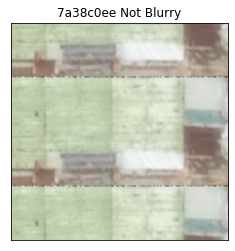

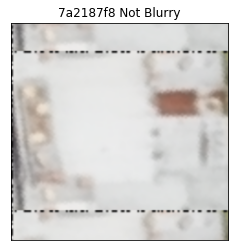

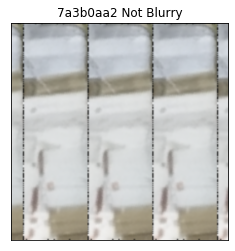

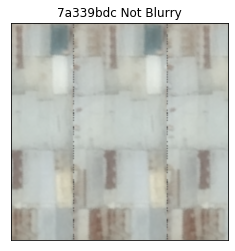

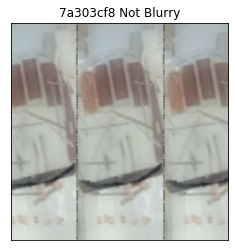

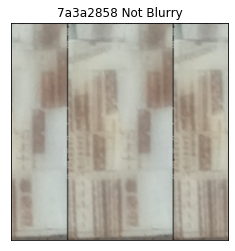

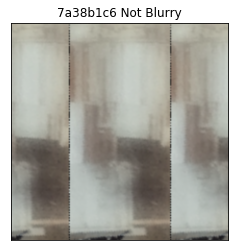

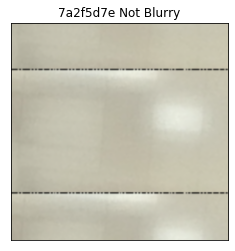

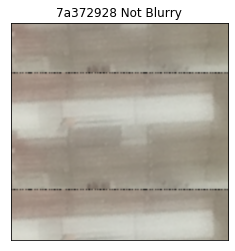

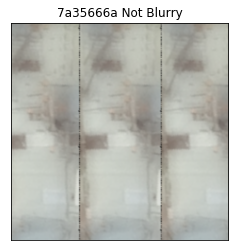

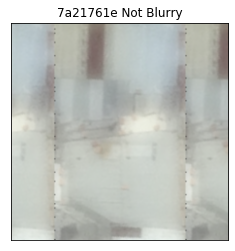

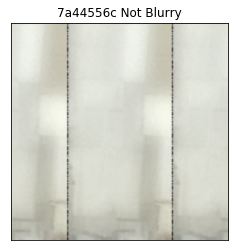

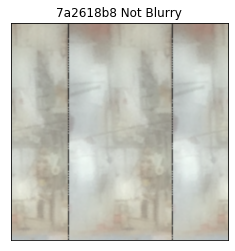

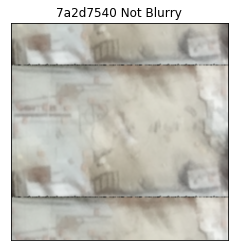

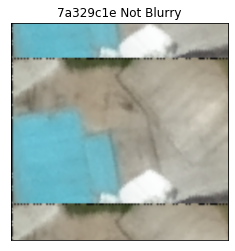

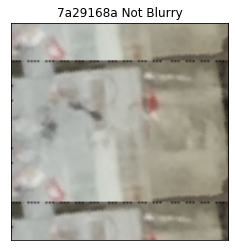

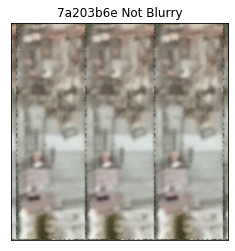

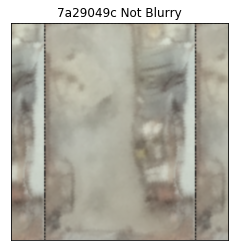

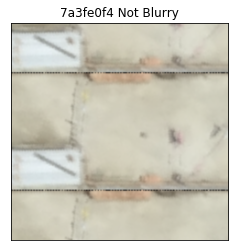

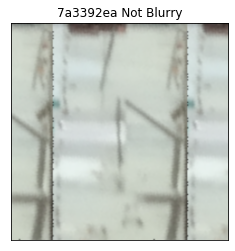

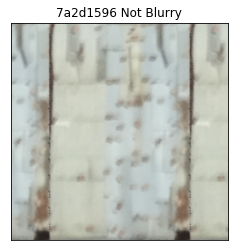

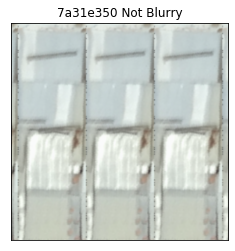

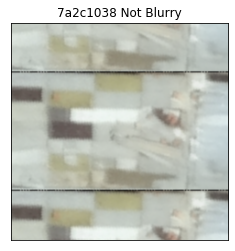

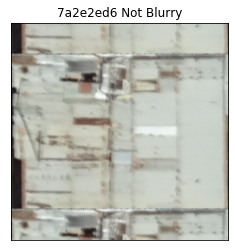

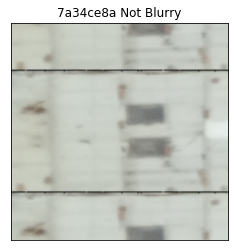

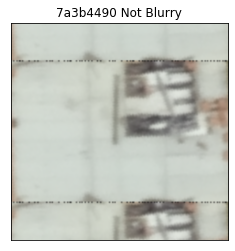

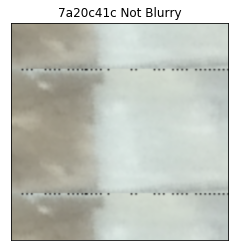

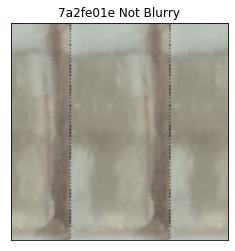

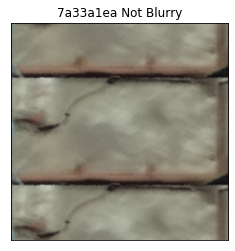

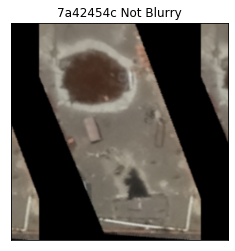

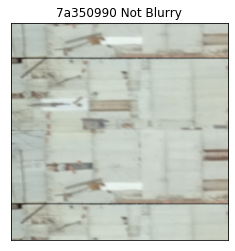

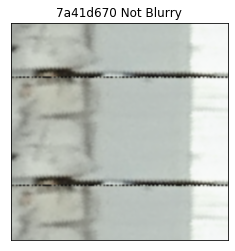

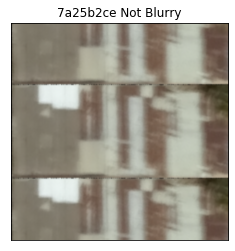

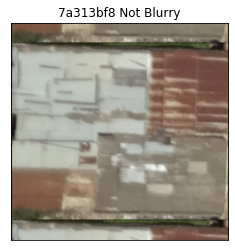

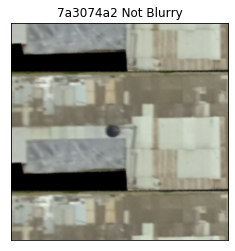

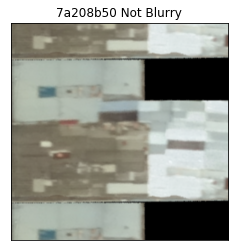

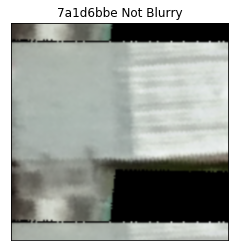

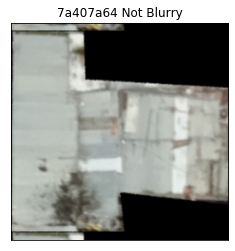

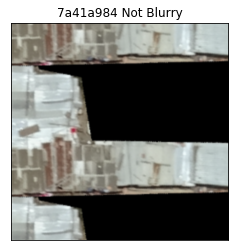

In [29]:
image_quality=calc_bluriness(nhm_images)

In [30]:
len(image_quality.keys())

7736

see Hands-On-Image-Processing-with-Python-master/Chapter5.ipynb

In [31]:
def pil_unsharp(image, radius, percent):
    im = Image.open(image)
    im1 = im.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent))
    return im1

In [32]:
def skimage_unsharp_mark(img, radius, ammount):
    im = imread(img)
    im1 = unsharp_mask(im, radius=radius, amount=ammount)
    return im1

Unsharpen mask in PIL looks to be doing a better job than skimage 

In [33]:
def img_type_av_sz(fn_list):
    widths = []
    heights = []
    for im in fn_list:
        #100 x faster than open_image(img_f)
        if str(im).endswith('.tif'):
            w,h=Image.open(im).size
            widths.append(w)
            heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')
    return widths, heights

In [34]:
f_names = [data_dir/f'train/rotated/{border}/256/{f}' for f in listdir(data_dir/f'train/rotated/{border}/256/') if isfile(join(data_dir/f'train/rotated/{border}/256/', f))]

In [35]:
widths, heights=img_type_av_sz(f_names)

avg width: 256.0, avg height: 256.0, max w: 256, min w: 256, max h: 256, min h: 256


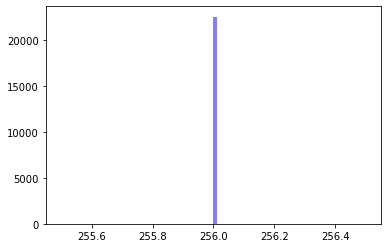

In [36]:
num_bins = 100
n, bins, patches = plt.hist(widths, num_bins, facecolor='blue', alpha=0.5)
plt.show()

### sharpen  blurry non healthy metal

In [37]:
radius=2
percent=150
for k, v in image_quality.items():
    if v=='Blurry':
        sharp_im=pil_unsharp(train_images/f'{k}.tif',radius,percent)
        sharp_im.save(train_images/f'balanced/{k}_sharp.tif')

In [38]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.05)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.2.
    # But we only blur about 10% of all images.
    iaa.Sometimes(0.1,
        iaa.GaussianBlur(sigma=(0, 0.2))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.Sometimes(0.1, iaa.ContrastNormalization((0.9, 1.1))),
    iaa.Sometimes(0.05, iaa.CropAndPad(percent=(0, 0.1))), 
    iaa.Fliplr(0.1), 
    iaa.Flipud(0.1), 
    iaa.Sometimes(0.1, iaa.Add((-20, 20))),
    #iaa.Sometimes(0.1, iaa.Sequential([
    #    iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
    #    iaa.WithChannels(0, iaa.Add((-5, 5))),
    #    iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
    #])),
    iaa.Sometimes(0.1, iaa.Sharpen(alpha=(0.0, 0.1))),
    #iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 0.1))),
    iaa.Sometimes(0.1, iaa.AdditiveGaussianNoise(scale=(0.0, 0.01*255))),
    iaa.Sometimes(0.05, iaa.Dropout(p=(0, 0.05))),
    # Make some images brighter and some darker.
    # In 5% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Sometimes(0.05, iaa.Multiply((0.9, 1.1), per_channel=0.05)),
    # Apply affine transformations to 20% of images.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Sometimes(0.25, iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10))),
    ], random_order=True)

/home/walle/miniconda3/envs/solaris/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [39]:
def apply_imgur(imgfiles, mul):
    img_shape = (256,256)

    #we need to do this n times
    for mc in range(int(mul)):
        X = np.zeros([len(imgfiles), img_shape[0], img_shape[1], 3], dtype=np.uint8)
        fnames=[]
        for index,f in enumerate(imgfiles):
            fname=f.split('.tif')[0]
            im = Image.open(f)
            X[index,:] = np.array(im)[:,:,0:3]
            fnames.append(fname)
        images_aug = seq.augment_images(X)
        dir_pth=data_dir/f'train/rotated/{border}/256/imgaug/'
        print(f'augmenting {len(images_aug)} images to {dir_pth}')
        assert len(images_aug)==len(fnames)
        if not os.path.exists(dir_pth):
            os.makedirs(dir_pth)
        ij = 0
        for b,f in zip(images_aug, fnames):
            im = Image.fromarray(b)
            im.save(dir_pth/f'{f}_imgaug_{mc}_{ij}.tif')
            ij+=1

In [40]:
apply_imgur(nhm_images, 5)

augmenting 7736 images to data/train/rotated/wrap/256/imgaug
augmenting 7736 images to data/train/rotated/wrap/256/imgaug
augmenting 7736 images to data/train/rotated/wrap/256/imgaug
augmenting 7736 images to data/train/rotated/wrap/256/imgaug
augmenting 7736 images to data/train/rotated/wrap/256/imgaug


In [5]:
imgaug_names = [f for f in listdir(data_dir/f'train/rotated/{border}/256/') if 'imgaug' in f]

In [6]:
imgaug_names[0]

'7a374dae_imgaug_3_5406.tif'

In [8]:
df_all.head()

id    roof_material  verified   country       region
0  7a3f2a10  concrete_cement      True  colombia  borde_rural
1  7a1f731e  irregular_metal      True  colombia  borde_rural
2  7a424ad8    healthy_metal      True  colombia  borde_rural
3  7a3edc5e    healthy_metal      True  colombia  borde_rural
4  7a303a6e    healthy_metal      True  colombia  borde_rural

In [9]:
aug=[]
for f in imgaug_names:
    n=f.split('_')[0]
    aug.append(n)

In [10]:
augmented=list(set(aug))

In [11]:
augmented[0]

'7a347c5a'

In [12]:
df_aug=df_all.copy()

Create new df containing non and augmented copies of images

In [13]:
for i,f in enumerate(imgaug_names):
    if (i%1000)==0:
        print(i)
    n=f.split('_')[0]
    row=df_all.loc[df_all['id'] == n]
    d=row.reset_index().to_dict(orient='records')
    if len(d)>0:
        d=d[0]
        t=f.split('.tif')[0]
        d['id']=t
        del d['index']
        df_aug=df_aug.append(d, ignore_index=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [14]:
df_aug.tail()

id    roof_material  verified    country  \
61228   7a3d40e2_imgaug_0_589  irregular_metal      True   colombia   
61229   7a41538a_imgaug_1_555  irregular_metal      True   colombia   
61230  7a28b708_imgaug_2_4114  irregular_metal      True   colombia   
61231  7a2f3042_imgaug_1_1290       incomplete      True   colombia   
61232  7a2c65ce_imgaug_1_7114  irregular_metal      True  guatemala   

                     region  
61228           borde_rural  
61229           borde_rural  
61230          borde_soacha  
61231           borde_rural  
61232  mixco_1_and_ebenezer

In [15]:
len(df_all)

22553

In [16]:
len(df_aug)

61233

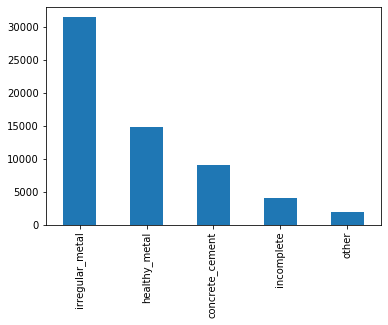

In [17]:
df_aug['roof_material'].value_counts().plot(kind='bar')

In [18]:
df_aug.to_csv(data_dir/f'df_aug_{border}.csv', index=False)

In [53]:
im1=Image.open(data_dir/f'train/rotated/{border}/256/7a44ca24.tif')
im2=Image.open(data_dir/f'train/rotated/{border}/256/7a44ca24_imgaug_0_3237.tif')
im3=Image.open(data_dir/f'train/rotated/{border}/256/7a44ca24_imgaug_1_3237.tif')
im4=Image.open(data_dir/f'train/rotated/{border}/256/7a44ca24_imgaug_2_3237.tif')

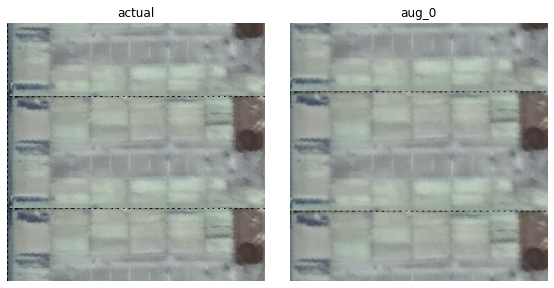

In [54]:
mpl_2_plot(im1, 'actual', im2, 'aug_0')

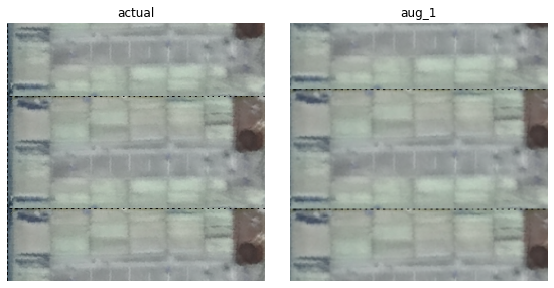

In [55]:
mpl_2_plot(im1, 'actual', im3, 'aug_1')

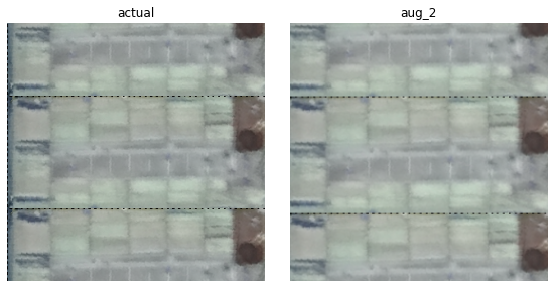

In [56]:
mpl_2_plot(im1, 'actual', im4, 'aug_2')